In [1]:
import ozzy as oz

In [2]:
ds = oz.open('ozzy', 'vphi_100.h5')


Reading the following files:
    -> read took: 0:00:00.094728


In [3]:
ds

<xarray.Dataset> Size: 21MB
Dimensions:  (t: 133, x1: 20000)
Coordinates:
  * t        (t) float64 1kB 2.6e+03 2.8e+03 3e+03 ... 2.86e+04 2.88e+04 2.9e+04
  * x1       (x1) float64 160kB -1e+03 -1e+03 -999.9 -999.9 ... -0.15 -0.1 -0.05
Data variables:
    vphi     (t, x1) float64 21MB dask.array<chunksize=(133, 20000), meta=np.ndarray>
Attributes:
    source:        vphi_100.h5
    files_prefix:  vphi_100.h5
    file_backend:  ozzy
    file_prefix:   vphi_100.h5
    data_origin:   ozzy

In [4]:
import matplotlib.pyplot as plt # noqa
import ozzy.plot as oplot # noqa
import seaborn as sns

sns.set_context('notebook')

In [5]:
import importlib
importlib.reload(plt)

<module 'matplotlib.pyplot' from '/Users/Mariana/miniconda3/envs/venv-general/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [6]:
maxval = float(ds['vphi'].max().compute())

(-200.0, 0.0)

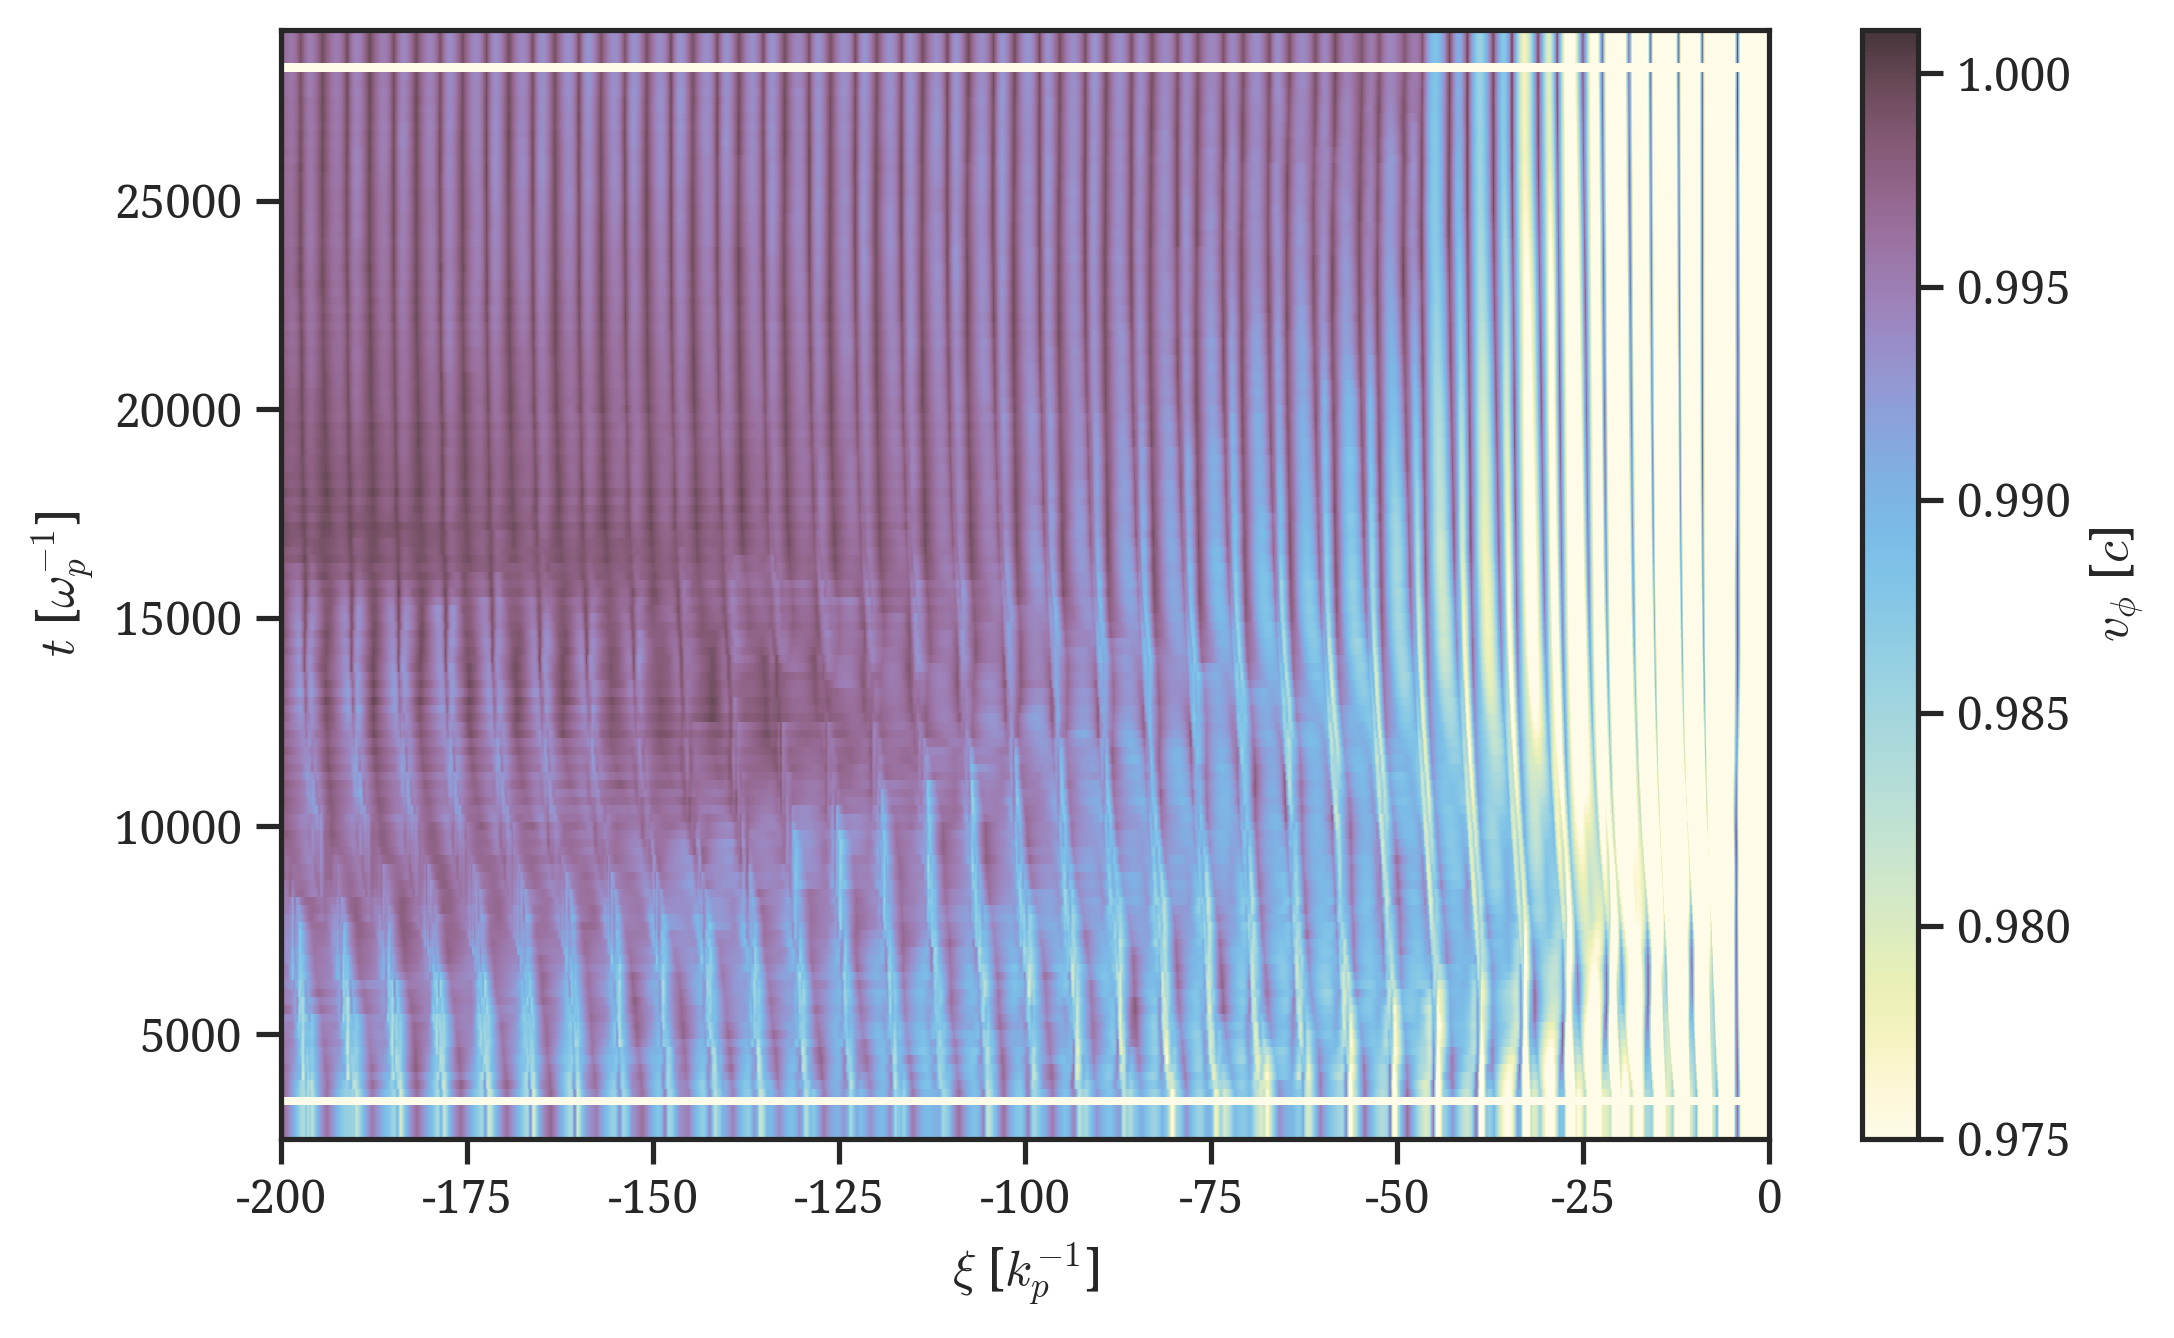

In [7]:
obj = ds['vphi'].plot()
obj.set_clim(0.975, maxval)
plt.xlim((-200,0))